In [1]:
# Machine Learning imports
from pyspark.ml.feature import VectorAssembler, StandardScaler
# Spark session and functions
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count

In [2]:
spark = SparkSession.builder.appName('CreditCardFraudDetection').getOrCreate()

24/12/03 22:56:45 WARN Utils: Your hostname, Nikhils-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.206 instead (on interface en0)
24/12/03 22:56:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/03 22:56:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/03 22:56:46 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Dataset
The dataset is available at [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [3]:
df = spark.read.csv('dataset/creditcard.csv', header=True, inferSchema=True).cache()

24/12/03 22:56:49 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


## Explaining the dataset
The dataset contains transactions made by credit cards in September 2013 by european cardholders. There are 28 features, all of them are numerical. The features V1, V2, ... V28 are the result of a PCA transformation. The only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.  
V1, V2, ... V28 are the principal components obtained with PCA. They have been anonymized to protect sensitive information.

In [4]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

# Preprocessing
## Checking for missing values
First, we check for missing values in the dataset. If there are any, we will clean them up.

In [5]:
# Checking for missing values
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(truncate=True)

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



In [6]:
original_size = df.count()
print(f'Original size: {original_size}')

# Clean up missing values
df_cleaned = df.na.drop()

cleaned_size = df_cleaned.count()
print(f'Cleaned size: {cleaned_size}')

Original size: 284807
Cleaned size: 284807


## Class distribution
We group the dataset by the 'Class' column to check the distribution of the classes.

In [7]:
# Checking for class distribution
df_cleaned.groupBy('Class').count().show()

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+



## Assembling the features
In PySpark MLlib, all input features should be combined into a single vector column. To do this, you use the `VectorAssembler`.  
This is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees.


In [8]:
# Select feature columns (all except 'Class', which is the label)
feature_columns = df_cleaned.columns[:-1]  # Assuming the last column is the label

# Assemble feature columns into a single vector column called "features"
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_transformed = assembler.transform(df_cleaned)

# Show the transformed data
df_transformed.select("features", "Class").show(5)

+--------------------+-----+
|            features|Class|
+--------------------+-----+
|[0.0,-1.359807133...|    0|
|[0.0,1.1918571113...|    0|
|[1.0,-1.358354061...|    0|
|[1.0,-0.966271711...|    0|
|[2.0,-1.158233093...|    0|
+--------------------+-----+
only showing top 5 rows



## Scaling the features
Feature scaling is important because some machine learning algorithms are sensitive to the scale of input data. You can scale features using the `StandardScaler`.
StandardScaler transforms a dataset of Vector rows, normalizing each feature to have unit standard deviation and/or zero mean. It takes parameters:
- `inputCol`: input column name.
- `outputCol`: output column name.
- `withStd`: True by default. Scales the data to unit standard deviation.
- `withMean`: False by default. Centers the data with mean before scaling. It will build a dense output, so take care when applying to sparse input.

In [9]:
# Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
df_scaled = scaler.fit(df_transformed).transform(df_transformed)

# Summary of the scaling process
print(f"Mean: {scaler.explainParams()}")
# print(f"Standard Deviation: {scaler.std}")

# Show the scaled data
df_scaled.select("scaled_features", "Class").show(5)

Mean: inputCol: input column name. (current: features)
outputCol: output column name. (default: StandardScaler_ea0f858ed3ca__output, current: scaled_features)
withMean: Center data with mean (default: False, current: False)
withStd: Scale to unit standard deviation (default: True, current: True)
+--------------------+-----+
|     scaled_features|Class|
+--------------------+-----+
|[0.0,-0.694241102...|    0|
|[0.0,0.6084952594...|    0|
|[2.10578867609768...|    0|
|[2.10578867609768...|    0|
|[4.21157735219537...|    0|
+--------------------+-----+
only showing top 5 rows



In [10]:
df_scaled.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+--------------------+--------------------+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|    

## Handling Class imbalance
From the class distribution, we can see that the dataset is highly imbalanced. The number of non-fraudulent transactions is much higher than the number of fraudulent transactions. For our model to learn effectively, we need to balance the classes.  
This can be done in two ways:
1. **Undersampling**: In this method, we randomly sample the majority class to match the minority class. This can lead to loss of information.
2. **Oversampling**: In this method, we randomly duplicate the minority class to match the majority class. This can lead to overfitting.

With this dataset, we will use the undersampling method as the dataset is large enough to not lose much information.

In [11]:
# Count the number of fraudulent and non-fraudulent transactions
fraud_count = df_scaled.filter(col('Class') == 1).count()
non_fraud_count = df_scaled.filter(col('Class') == 0).count()
print(f"Fraudulent transactions: {fraud_count}\nNon-fraudulent transactions: {non_fraud_count} before balancing")

# Undersampling the non-fraudulent transactions
df_fraud = df_scaled.filter(col('Class') == 1)
df_non_fraud = df_scaled.filter(col('Class') == 0).sample(fraction=fraud_count/non_fraud_count)

# Combine the two classes
df_balanced = df_fraud.union(df_non_fraud)

# Count the number of fraudulent and non-fraudulent transactions after balancing
df_balanced.groupBy('Class').count().show()

Fraudulent transactions: 492
Non-fraudulent transactions: 284315 before balancing
+-----+-----+
|Class|count|
+-----+-----+
|    1|  492|
|    0|  460|
+-----+-----+



# Splitting the dataset
Now that we have completed the preprocessing steps, we can split the dataset into training and testing sets.

In [12]:
train_df, test_df = df_balanced.randomSplit([0.8, 0.2], seed=42)
print(f"Training set size: {train_df.count()}")
print(f"Testing set size: {test_df.count()}")

Training set size: 774


Testing set size: 178


In [13]:
train_df.show(5)

+------+-------------------+-----------------+-----------------+----------------+------------------+-----------------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+-----------------+--------------------+-----------------+-----------------+-------------------+-----------------+-------------------+-----------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+------+-----+--------------------+--------------------+
|  Time|                 V1|               V2|               V3|              V4|                V5|               V6|               V7|                 V8|                V9|               V10|               V11|               V12|               V13|              V14|                 V15|              V16|              V17|                V18|              V19|                V20|              V21|    

In [14]:
# Import the Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create a Random Forest Classifier
rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="Class")
model = rf.fit(train_df)

In [15]:
# Make predictions on the test set
predictions = model.transform(test_df)

In [16]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="Class")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9737045133084739


In [17]:
predictions.show(5)

+------+------------------+----------------+------------------+----------------+------------------+-------------------+------------------+------------------+------------------+-----------------+----------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|  Time|                V1|              V2|                V3|              V4|                V5|                 V6|                V7|                V8|                V9|              V10|             V11|              V12|               V13|              V14|               V15|               V16|              V17|              V18|               V19

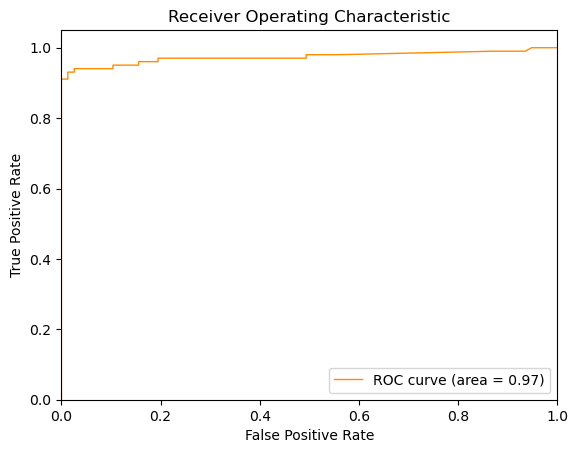

In [18]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Convert the predictions to a Pandas DataFrame
predictions_df = predictions.select('Class', 'probability').toPandas()

# Get the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(predictions_df['Class'], predictions_df['probability'].apply(lambda x: x[1]))

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Save the model
Now that we have trained the model, we can save it for future use. This will come in handy when we want to make predictions on new data or introduce streaming data.

In [19]:
model.write().overwrite().save('models/credit_card_fraud_detection_model')

In [20]:
# Stop the Spark session
spark.stop()